In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.stattools as sts 
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')
# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff

# pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# TASK1

### Load the Data

In [2]:
df_test=pd.read_csv("DS3_C1_S4_DailyDelhiClimateTest_Data_Practice.csv", parse_dates=['date']).set_index('date')
df=pd.read_csv("DS3_C1_S4_DailyDelhiClimateTrain_Data_Practice (1).csv", parse_dates=['date']).set_index('date')
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [4]:
df.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

### Visualization

#### Exploring Daily Mean Temprature of Delhi

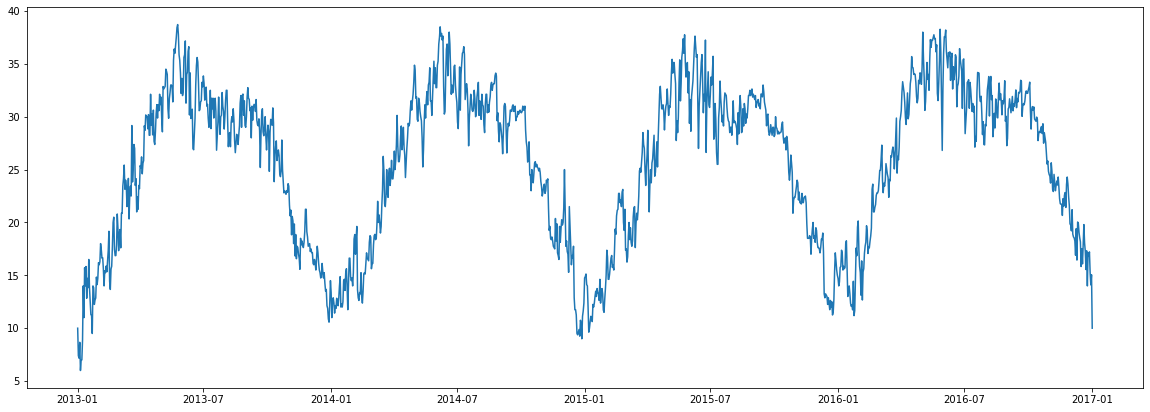

In [5]:
plt.figure(figsize=(20,7))
plt.plot(df.meantemp);

#### From the above Graph we can see that our data has additive seasonality.

### Decomposing the Data - To visualize the Different Components of the Daily Data

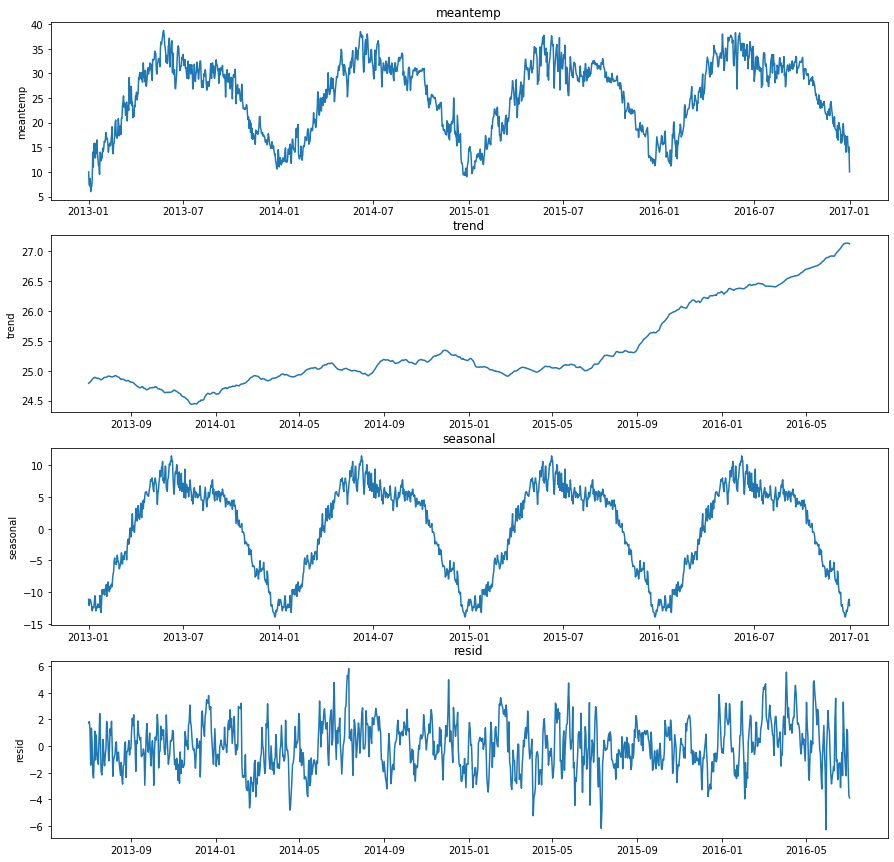

In [6]:
df.sort_index(inplace=True)
decomposition = seasonal_decompose(df['meantemp'], model='additive',period=365)

dt=decomposition.trend
ds=decomposition.seasonal
dr=decomposition.resid

a= [df['meantemp'],dt,ds,dr]

# Trend
fig , axes =plt.subplots(4,1, figsize=(15,15))
for i ,ax in zip(a,axes.flatten()):
    ax.plot(i)
    ax.set_ylabel(i.name)
    ax.set_title(i.name)

### Decomposing the Data - To visualize the Different Components of the Monthly Data

In [7]:
df_m=df['meantemp']
df_m.head()

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Name: meantemp, dtype: float64

In [66]:
df_weekly = df_m.resample('W').mean()
df_weekly.head()
df_test = df_test.resample('W').mean()
df_weekly.head()

date
2013-01-06     7.705556
2013-01-13    12.343537
2013-01-20    13.642857
2013-01-27    12.329592
2013-02-03    15.736905
Freq: W-SUN, Name: meantemp, dtype: float64

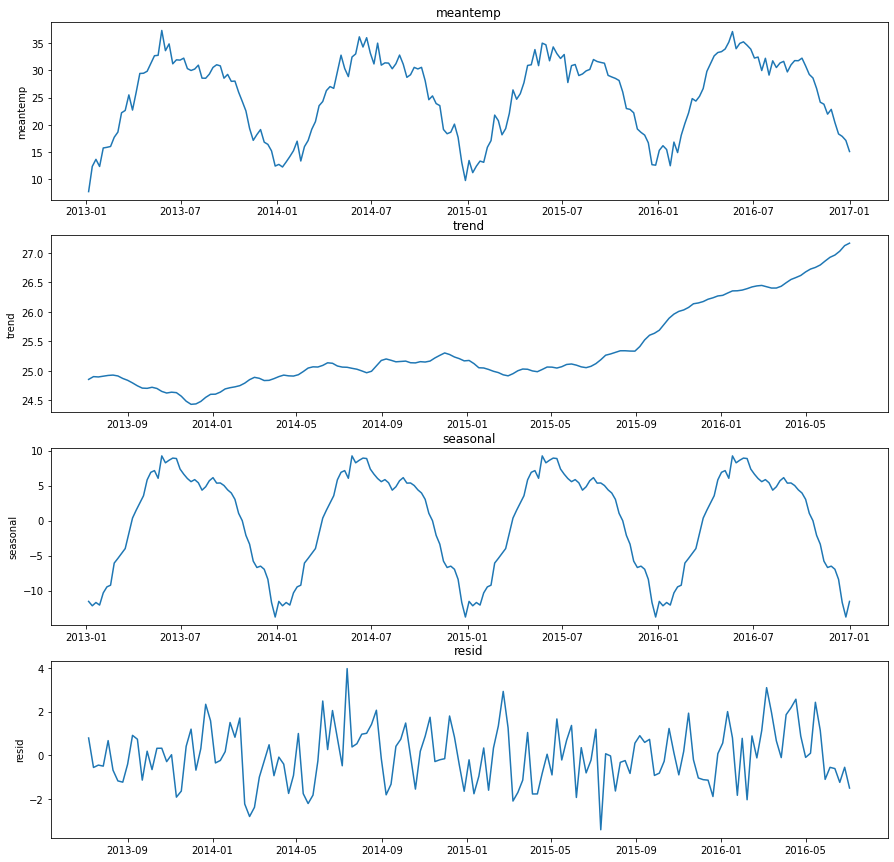

In [10]:
decomposition = seasonal_decompose(df_weekly, model='additive')

dt=decomposition.trend
ds=decomposition.seasonal
dr=decomposition.resid

a= [df_weekly,dt,ds,dr]

# Trend
fig , axes =plt.subplots(4,1, figsize=(15,15))
for i ,ax in zip(a,axes.flatten()):
    ax.plot(i)
    ax.set_ylabel(i.name)
    ax.set_title(i.name)

### Data Smoothing

#### Daily Data

In [11]:
model_d = ExponentialSmoothing(df['meantemp'],trend='add',seasonal='add',seasonal_periods=30).fit()

Text(0.5, 1.0, 'Triple Exponent Smoothing')

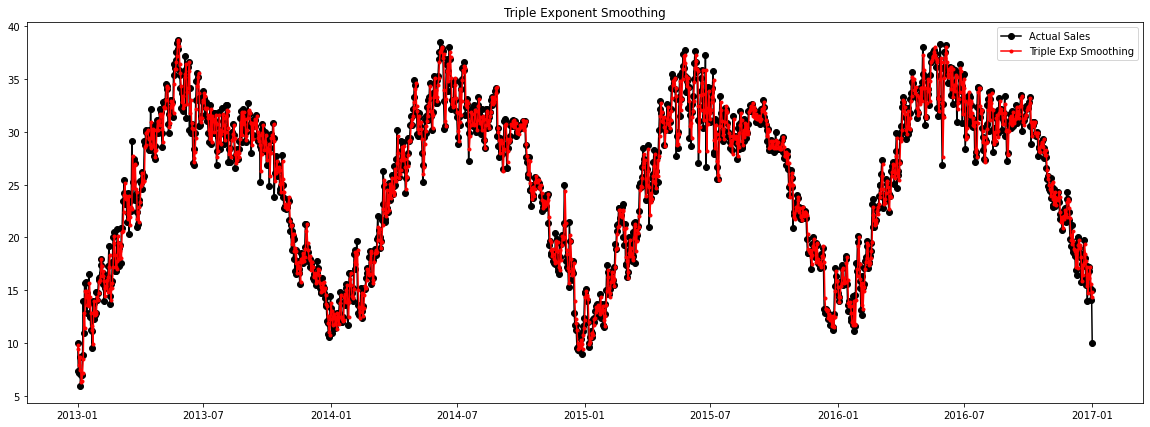

In [12]:
# plot the actual and triple smoothing values
plt.figure(figsize=(20,7))
plt.plot(df['meantemp'], marker='o',color='black',label='Actual Sales')
plt.plot(model_d.fittedvalues,marker='.',color='red',label='Triple Exp Smoothing')
plt.legend()
plt.title('Triple Exponent Smoothing')

#### Weekly Data

Text(0.5, 1.0, 'Triple Exponent Smoothing')

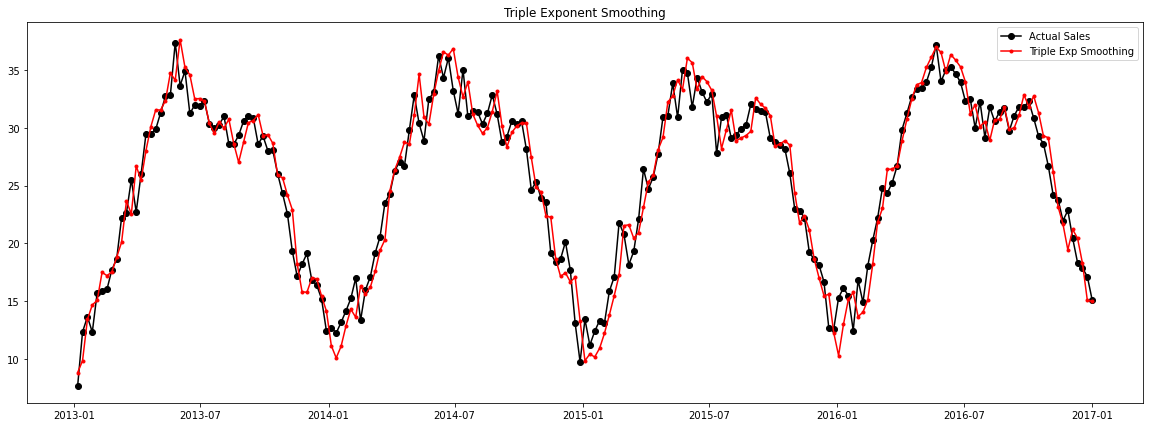

In [13]:
model = ExponentialSmoothing(df_weekly,trend='add',seasonal='add',seasonal_periods=30).fit()
# plot the actual and triple smoothing values
plt.figure(figsize=(20,7))
plt.plot(df_weekly, marker='o',color='black',label='Actual Sales')
plt.plot(model.fittedvalues,marker='.',color='red',label='Triple Exp Smoothing')
plt.legend()
plt.title('Triple Exponent Smoothing')

### To check if Data is Stationary 

In [33]:
pvalue = adfuller(df_weekly)[1]

if(pvalue>0.05):
    print('p-value={}. Data is not stationary'.format(pvalue))
else:
    print('p-value={}. Data is stationary'.format(pvalue))

p-value=6.898378388762679e-05. Data is stationary


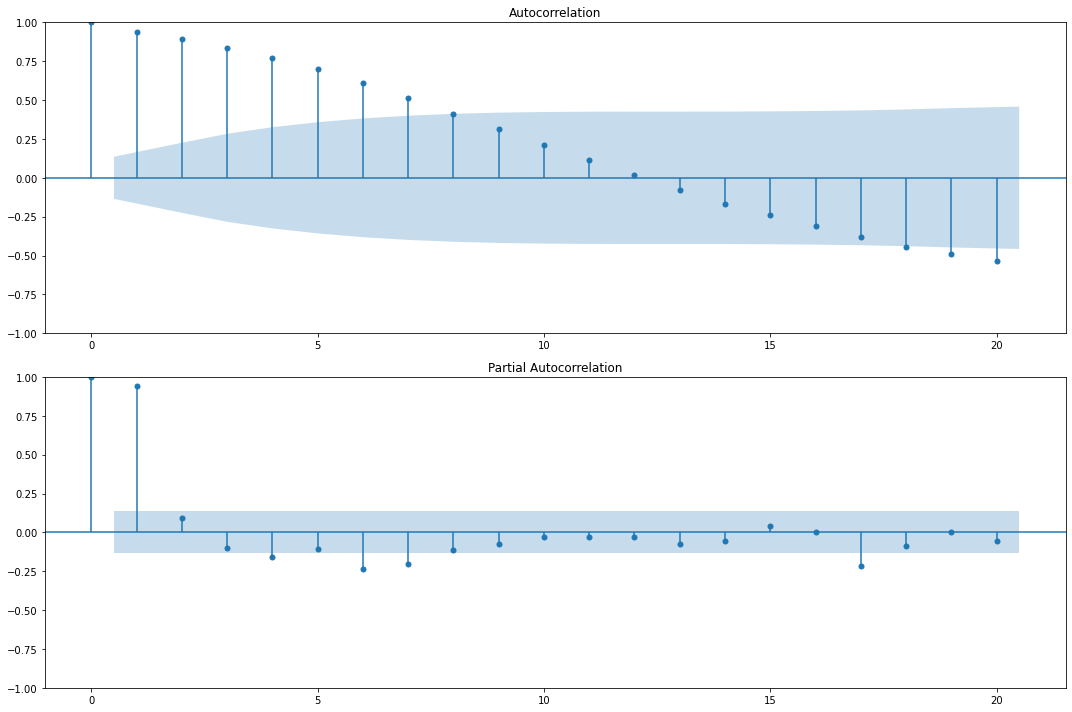

In [36]:
fig = plt.figure(figsize=(15, 10))

# Show ACF
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(df_weekly, lags=20, ax=ax1)

# Show PACF
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(df_weekly, lags=20, ax=ax2)

plt.tight_layout()

In [37]:
# auto ARIMA (to help in the selection of p,d,q)
m1 = auto_arima(df_weekly,start_p=0,max_p=5, start_q=0,max_q=40, seasonal=False)
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(2, 0, 4)   Log Likelihood                -431.247
Date:                Mon, 26 Dec 2022   AIC                            876.495
Time:                        14:43:07   BIC                            899.891
Sample:                    01-06-2013   HQIC                           885.954
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8176      0.075     24.301      0.000       1.671       1.964
ar.L2         -0.8204      0.075    -10.993      0.000      -0.967      -0.674
ma.L1         -1.0240      0.104     -9.828      0.0

## TASK- ARIMA Model

In [104]:
m1 = ARIMA(df_weekly,order=(2,0,3))
r1 = m1.fit()
print(r1.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                  209
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -421.794
Date:                Mon, 26 Dec 2022   AIC                            857.588
Time:                        15:15:42   BIC                            880.984
Sample:                    01-06-2013   HQIC                           867.047
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2493      0.398     63.516      0.000      24.470      26.028
ar.L1          1.9749      0.006    305.450      0.000       1.962       1.988
ar.L2         -0.9894      0.006   -158.912      0.0

#### Mean Temprature of Delhi

In [71]:
predictions = r1.predict(len(df_weekly),len(df_weekly)+(len(df_test)-1))
predictions

2017-01-08    14.898321
2017-01-15    14.499745
2017-01-22    14.219692
2017-01-29    14.102378
2017-02-05    14.147773
2017-02-12    14.353490
2017-02-19    14.714846
2017-02-26    15.224952
2017-03-05    15.874840
2017-03-12    16.653611
2017-03-19    17.548614
2017-03-26    18.545651
2017-04-02    19.629196
2017-04-09    20.782633
2017-04-16    21.988514
2017-04-23    23.228813
2017-04-30    24.485200
2017-05-07    25.739305
Freq: W-SUN, Name: predicted_mean, dtype: float64

### Creating Dataframe of Acctual, Predicted and ERROR

In [73]:
DF = pd.DataFrame({'Acctual':df_test['meantemp'],'Predicted':predictions,'Error': (df_test['meantemp']-predictions)}).dropna()
DF

,Acctual,Predicted,Error
2017-01-08,17.487247,14.898321,2.588925
2017-01-15,13.191727,14.499745,-1.308018
2017-01-22,14.732486,14.219692,0.512793
2017-01-29,17.239193,14.102378,3.136814
2017-02-05,16.839757,14.147773,2.691983
2017-02-12,15.661508,14.353490,1.308018
2017-02-19,19.402628,14.714846,4.687782
2017-02-26,19.976190,15.224952,4.751238
2017-03-05,21.542125,15.874840,5.667284
2017-03-12,20.114572,16.653611,3.460961


### Ploting Acctual, Predicted and ERROR

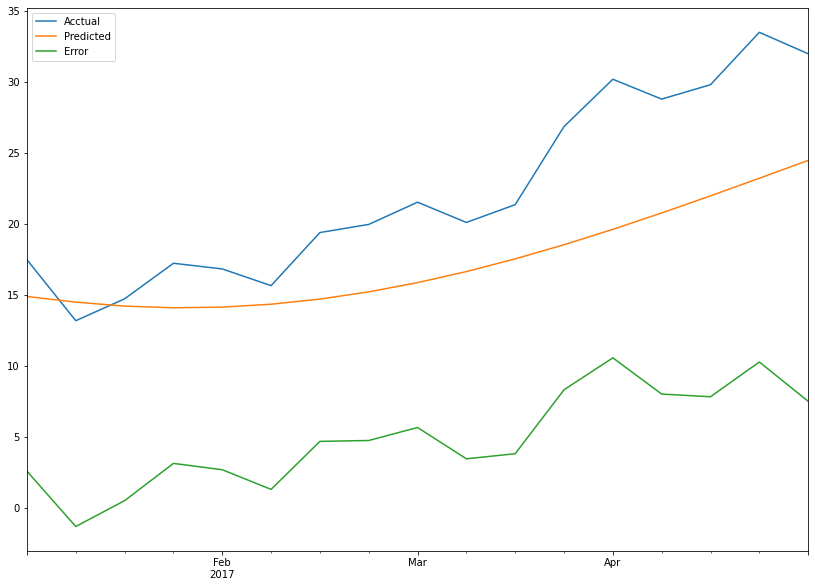

In [75]:
DF.plot(figsize=(14,10));

### Perform the LJung-Box test

In [76]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(r1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


### Calculate MSE and RMSE of the Model from the test

In [77]:
# MSE
msg = 'ARMA Model. Order=(' + str(5) + ',' + str(3) + ')'
mse1 = mean_squared_error(DF.Acctual, DF.Predicted)
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(5,3)
	MSE = 35.27987423603812
	RMSE = 5.939686375225389


# TASK3 - Sarimax Model

In [91]:
p=2; q=3; d=0
m1 = sm.tsa.statespace.SARIMAX(df_weekly,order=(p,d,q),seasonal_order=(p,d,q,52)).fit()

In [92]:
predictions = m1.predict(start=len(df_weekly),end=len(df_weekly)+(len(df_test)-1),dynamic=True)
predictions

2017-01-08    15.453378
2017-01-15    15.795905
2017-01-22    15.409832
2017-01-29    16.150519
2017-02-05    16.528222
2017-02-12    14.791980
2017-02-19    16.062700
2017-02-26    16.424167
2017-03-05    17.665596
2017-03-12    18.096276
2017-03-19    19.719440
2017-03-26    19.453810
2017-04-02    20.728614
2017-04-09    21.563505
2017-04-16    21.350310
2017-04-23    22.637755
2017-04-30    24.006678
2017-05-07    23.201557
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [93]:
df_res = pd.DataFrame({'actual':df_test['meantemp'],'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
df_res.dropna(inplace=True)
print(df_res)

               actual  predicted        err
2017-01-08  17.487247  15.453378   2.033868
2017-01-15  13.191727  15.795905  -2.604178
2017-01-22  14.732486  15.409832  -0.677347
2017-01-29  17.239193  16.150519   1.088674
2017-02-05  16.839757  16.528222   0.311535
2017-02-12  15.661508  14.791980   0.869528
2017-02-19  19.402628  16.062700   3.339928
2017-02-26  19.976190  16.424167   3.552023
2017-03-05  21.542125  17.665596   3.876528
2017-03-12  20.114572  18.096276   2.018296
2017-03-19  21.368346  19.719440   1.648905
2017-03-26  26.871429  19.453810   7.417619
2017-04-02  30.203515  20.728614   9.474901
2017-04-09  28.805189  21.563505   7.241684
2017-04-16  29.820862  21.350310   8.470552
2017-04-23  33.511508  22.637755  10.873753
2017-04-30  32.000000  24.006678   7.993322


### Calculate error terms

In [94]:
mean_squared_error(df_res.actual,df_res.predicted)

30.00741980996528

<AxesSubplot:>

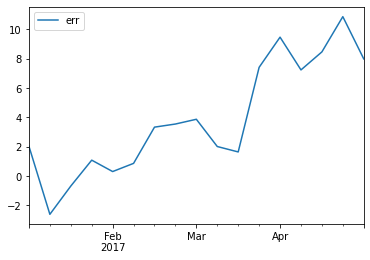

In [95]:
 df_res[["err"]].plot()

<AxesSubplot:>

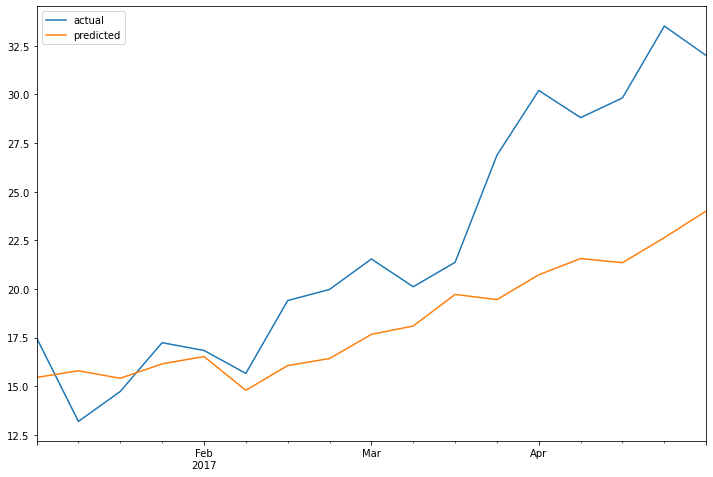

In [96]:
df_res[['actual','predicted']].plot(figsize=(12,8))